In [ ]:
import os
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder

from google.colab import files
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip  -q /content/drive/MyDrive/DL_Project/train-data.zip -d /content/train-data
# !unzip  -q /content/drive/MyDrive/DL_Project/test-data.zip -d /content/test-data

!unzip -q /content/drive/MyDrive/College/3.\ Junior/Winter\ Semester/CS\ 474/Final\ DL/Car_Data/train-data.zip -d /content/train-data
!unzip -q /content/drive/MyDrive/College/3.\ Junior/Winter\ Semester/CS\ 474/Final\ DL/Car_Data/test-data.zip -d /content/test-data

# Load Data

In [ ]:
# read in train and test data
train_data = pd.read_csv("/content/train-data/train-data.csv", na_values = ["null bhp"])
test_data = pd.read_csv("/content/test-data/test-data.csv", na_values = ["null bhp"])

# Clean Data

In [ ]:
# remove unnecessary parameters
train_data.drop("New_Price", axis = 1, inplace = True)
train_data.drop("Unnamed: 0", axis = 1, inplace = True)
train_data.drop(["Name", "Location"], axis = 1, inplace = True)
train_data["Seats"].fillna(train_data["Seats"].value_counts().values[0], inplace = True)

# remove rows with missing values
train_data.dropna(inplace = True)

In [ ]:
# function to convert columns from string to float
def convert_data(val):
    if not pd.isnull(val):

        # extract the numeric part of the string value
        return float(val.split(' ')[0])
        
    return val

### Convert column data

In [ ]:
# Convert 'Power' column to float and replace NA values with the mean
train_data["Power"] = train_data["Power"].apply(lambda val: convert_data(val))
train_data["Power"].fillna(train_data["Power"].mean(), inplace = True)


# Convert 'Engine' column to float and replace NA values with the mean
train_data["Engine"] = train_data["Engine"].apply(lambda val: convert_data(val))
train_data["Engine"].fillna(train_data["Engine"].median(), inplace = True)


# Convert 'Mileage' column to float
train_data["Mileage"] = train_data["Mileage"].apply(lambda val: convert_data(val))

# convert price units
train_data["Price"] = train_data["Price"] * 100000

In [ ]:
# Calculate the age of the car
# create a new column called 'Total Years' to replace the Year column
train_data['Total Years'] = datetime.datetime.now().year - train_data["Year"]
train_data.drop('Year', axis = 1, inplace = True)

### Format data

In [ ]:
# Define the categorical features and output feature to be used in the model
cat_features = ['Fuel_Type', 'Transmission', 'Owner_Type']
out_features = 'Price'

# Create a label encoder for the 'Fuel_Type' column and fit it to the data
# TODO Do we need this?
lbl_encoders = {}
lbl_encoders["Fuel_Type"] = LabelEncoder()
lbl_encoders["Fuel_Type"].fit_transform(train_data["Fuel_Type"])

# Create label encoders for each categorical feature and fit them to the data
lbl_encoders = {}
for features in cat_features:
    lbl_encoders[features] = LabelEncoder()
    train_data[features] = lbl_encoders[features].fit_transform(train_data[features])

In [ ]:
# Stack the categorical features horizontally and convert them to a tensor
cat_features = np.stack([train_data["Fuel_Type"], train_data["Transmission"], train_data["Owner_Type"]], axis = 1)
cat_features = torch.tensor(cat_features, dtype = torch.int64)

# Create a list of continuous features for every column 
# except the categorical or the target features ('Price')
cont_features = []
for i in train_data.columns:
    if i in ['Fuel_Type', 'Transmission', 'Owner_Type', 'Price']:
        pass
    else:
        cont_features.append(i)

In [ ]:
# Stack the continuous features horizontally and convert them to a tensor
cont_features = np.stack([train_data[i].values for i in cont_features], axis = 1)
cont_features = torch.tensor(cont_features, dtype = torch.float)

# Convert the target feature to a tensor and reshape it
y = torch.tensor(train_data['Price'].values,dtype=torch.float).reshape(-1,1)

# Get the number of unique values for each categorical feature
cat_dims = [train_data[i].nunique() for i in ["Fuel_Type", "Transmission", "Owner_Type"]]

# Set the embedding dimensions for each categorical feature 
# based on the number of unique values
embedding_dim = [(i, min(50, (i+1) // 2)) for i in cat_dims]

### Embed training data

In [ ]:
# Create Embedding layers for categorical features
embed_rep = nn.ModuleList([nn.Embedding(i,e) for i,e in embedding_dim])

# Embed categorical features and concatenate the resulting tensors
embedding_value = []
for ind, e in enumerate(embed_rep):
    embedding_value.append(e(cat_features[:, ind]))
    
z = torch.cat(embedding_value, 1)

# Apply 40% dropout to the concatenated tensor
drpout = nn.Dropout(0.4)
z = drpout(z)

# Neural Network

In [ ]:
class UsedCarPricePredictionNN(nn.Module):
    def __init__(self, cat_dim, n_cont, layers, out_sz, p=0.5):
        super().__init__()
                
        # Define the embedding layer for categorical features
        embedded_dim = [(i, min(50, (i+1) // 2)) for i in cat_dim]
        self.embd_list = nn.ModuleList([nn.Embedding(inp, out) for inp, out in embedded_dim])
        
        # Define the dropout and batch normalization layer for continuous features
        self.drpout = nn.Dropout(p)
        self.batchnorm = nn.BatchNorm1d(n_cont)
        
        # Define a simple feedforward neural network architecture with one layer
        layerslist = []
        n_emb = sum([out for inp, out in embedded_dim])
        n_in = n_emb + n_cont
        
        for i in layers:
            layerslist.append(nn.Linear(n_in, i))
            layerslist.append(nn.ReLU(inplace = True))
            layerslist.append(nn.BatchNorm1d(i))
            layerslist.append(nn.Dropout(p))
            n_in = i
        layerslist.append(nn.Linear(layers[-1], out_sz))
        
        self.layers = nn.Sequential(* layerslist)
        
        
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i, e in enumerate(self.embd_list):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)

        # Apply dropout
        x = self.drpout(x)
        
        # Apply batch normalization to the continuous features
        x_cont = self.batchnorm(x_cont)
        
        # Concatenate the embeddings and continuous features
        x = torch.cat([x, x_cont], axis=1)
                
        # Pass the concatenated features through the feedforward neural network
        x = self.layers(x)
        
        return x

### Initialize model and data

In [ ]:
# Set the random seed to ensure reproducibility
torch.manual_seed(100)

# nstantiate the neural network model
model = UsedCarPricePredictionNN(cat_dims, 6, [100, 50], 1, p = 0.4)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)

# Set the batch size and test size
batch_size = 6000
test_size = int(batch_size*0.15)

# split the categorical features into train and test sets
train_categorical = cat_features[:batch_size-test_size]
test_categorical = cat_features[batch_size-test_size:batch_size]

# split the continuous features
train_cont = cont_features[:batch_size-test_size]
test_cont = cont_features[batch_size-test_size:batch_size]

# split the target variables
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

# len(train_categorical),len(test_categorical),len(train_cont),len(test_cont),len(y_train),len(y_test)

### Train

In [ ]:
epochs = 2400
final_losses = []

for i in range(epochs):
    # TODO why is this line here?
    i=i+1

    # perform a forward pass through the model
    y_pred = model(train_categorical,train_cont)

    # Calculate the root mean squared loss
    loss = torch.sqrt(loss_function(y_pred,y_train))
    final_losses.append(loss)

    # Print the epoch and loss regularly
    if i % 100 == 1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))

    # Backward pass to calculate gradients and update for each parameter
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch number: 1 and the loss : 1472162.125
Epoch number: 101 and the loss : 1468921.125
Epoch number: 201 and the loss : 1456600.75
Epoch number: 301 and the loss : 1434834.625
Epoch number: 401 and the loss : 1404819.375
Epoch number: 501 and the loss : 1366380.875
Epoch number: 601 and the loss : 1318217.0
Epoch number: 701 and the loss : 1265031.25
Epoch number: 801 and the loss : 1204389.125
Epoch number: 901 and the loss : 1136968.375
Epoch number: 1001 and the loss : 1063197.375
Epoch number: 1101 and the loss : 987369.9375
Epoch number: 1201 and the loss : 902817.625
Epoch number: 1301 and the loss : 826141.5625
Epoch number: 1401 and the loss : 741809.125
Epoch number: 1501 and the loss : 668040.25
Epoch number: 1601 and the loss : 607843.6875
Epoch number: 1701 and the loss : 545701.6875
Epoch number: 1801 and the loss : 502495.375
Epoch number: 1901 and the loss : 485526.28125
Epoch number: 2001 and the loss : 468251.21875
Epoch number: 2101 and the loss : 458547.21875
Epoch 

In [ ]:
type(final_losses[0])

torch.Tensor

Text(0.5, 0, 'epoch')

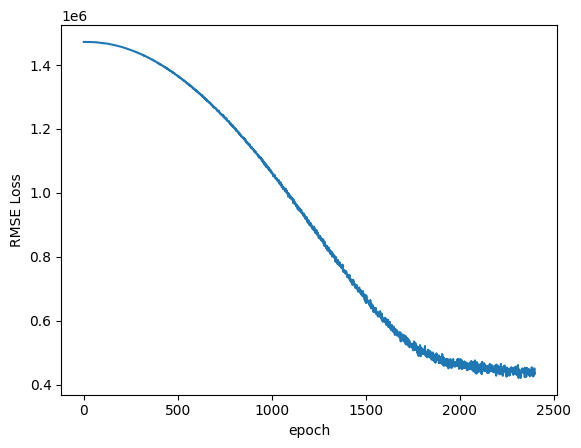

In [ ]:
# show training results
final_losses = [f.detach().numpy() for f in final_losses]
plt.plot(range(epochs), final_losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')

### Show training results

In [ ]:
# Make predictions on the test dataset
y_pred = ""
with torch.no_grad():
    y_pred = model(test_categorical,test_cont)
    loss = torch.sqrt(loss_function(y_pred,y_test))
    
print('RMSE: {}'.format(loss))

RMSE: 621493.75


In [ ]:
# store test and prediction data
data_verify = pd.DataFrame(y_test.tolist(), columns=["Test"])
data_predicted = pd.DataFrame(y_pred.tolist(), columns=["Prediction"])

# calculate the difference between  "Test" and "Prediction"
final_output = pd.concat([data_verify, data_predicted],axis=1)
final_output['Difference']=final_output['Test'] - final_output['Prediction']
final_output = final_output / (100000)

In [ ]:
# save model network
torch.save(model,'SalePrice.pt')
torch.save(model.state_dict(),'PriceWeights.pt')

# Validation

In [ ]:
# load a new instance of the model with the trained weights
cat_size = [4,2,4]
model1 = UsedCarPricePredictionNN(cat_size, 6, [100, 50], 1, p=0.4)
model1.load_state_dict(torch.load('PriceWeights.pt'))

# set model to eval mode to ensure that any 
# dropout layers or batch normalization layers are properly handled
model1.eval()

UsedCarPricePredictionNN(
  (embd_list): ModuleList(
    (0): Embedding(4, 2)
    (1): Embedding(2, 1)
    (2): Embedding(4, 2)
  )
  (drpout): Dropout(p=0.4, inplace=False)
  (batchnorm): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [ ]:
# initialize new validation data
catee = np.array([1,1,0])
conti = np.array([4.1000e+04, 1.9670e+01, 1.5820e+03, 1.2620e+02, 5.0000e+00, 6.0000e+00])

# format validation data
catee = torch.tensor(catee.reshape(1,3), dtype = torch.int64)
conti = torch.tensor(conti.reshape(1,6), dtype= torch.float)

# compute price prediction
model1(catee, conti)

tensor([[1125195.]], grad_fn=<AddmmBackward0>)